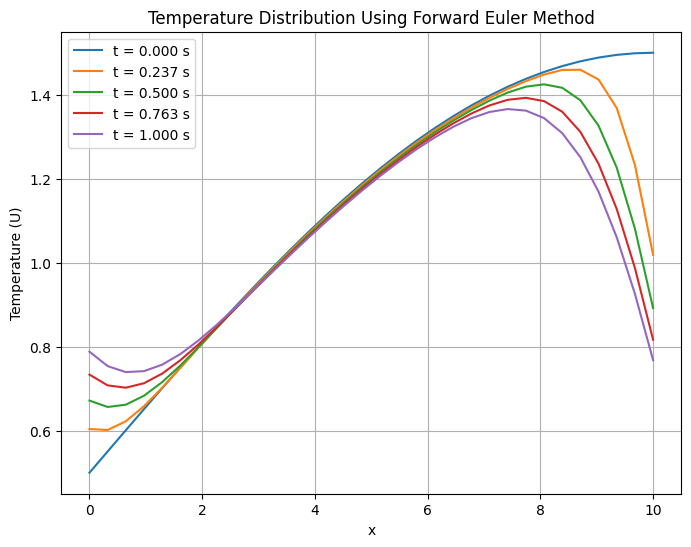

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Here we use Forward Euler method to simulate the heat equation with Robin boundary conditions

## Defining Simulation Parameters
Lx = 10       # Length of the spatial domain
T = 1         # Total simulation time
n_x = 5       # number of qubits for spatial variable x: Nx = 2^n_x
Nx = 2 ** n_x # Number of spatial points
dx = Lx / (Nx - 1)  # Spatial grid spacing

## Heat Equation Parameters and CFL Stability
alpha = 1     # Thermal diffusivity u_t = \alpha u_xx
r = 1/4       # CFL number (for stability in Forward Euler)
Nt = int(np.ceil(T / (dx ** 2 * r / alpha)))  # Time steps determined by CFL
dt = T / (Nt - 1)  # Time step size

## Robin Boundary Condition Coefficients
h1, g1 = 1/2, 1/4  # Left boundary:  ∂U/∂x + h1 U = g1
h2, g2 = 1,   1/4  # Right boundary:  ∂U/∂x + h2 U = g2

## Creating Grids and Initializing Solution Array
x = np.linspace(0, Lx, Nx)   # Spatial grid
t = np.linspace(0, T, Nt)    # Temporal grid
U = np.zeros((Nx, Nt))       # Solution array: U(x, t)

## Setting the Initial Condition
U[:, 0] = np.cos(np.pi * (Lx - x) / (2 * Lx)) + 1/2

##Time-stepping Loop using Forward Euler Method
for n in range(Nt - 1):
    # Interior update via Forward Euler (explicit scheme for the heat equation)
    U[1:-1, n + 1] = (
        dt / dx**2 * U[2:, n] +
        (1 - 2 * dt / dx**2) * U[1:-1, n] +
        dt / dx**2 * U[:-2, n]
    )

    # Left boundary: Forward Euler with Robin condition
    U[0, n + 1] = (
        2 * dt / dx**2 * U[1, n] +
        (1 - 2 * dt / dx**2 + 2 * dt / dx * h1) * U[0, n] -
        2 * dt / dx * g1
    )

    # Right boundary: Forward Euler with Robin condition
    U[Nx - 1, n + 1] = (
        (1 - 2 * dt / dx**2 - 2 * dt / dx * h2) * U[Nx - 1, n] +
        2 * dt / dx**2 * U[Nx - 2, n] +
        2 * dt / dx * g2
    )

## Plotting Temperature Evolution Over Time
time_steps = [0, int(Nt / 4), int(Nt / 2), int(3 * Nt / 4), Nt - 1]
plt.figure(figsize=(8, 6))
for n in time_steps:
    plt.plot(x, U[:, n], label=f't = {t[n]:.3f} s')

##Formatting the Plot
plt.xlabel('x')
plt.ylabel('Temperature (U)')
plt.title('Temperature Distribution Using Forward Euler Method')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
n_xi = 8 # number of qubits for the additional schrodingersation variable ξ
L_xi = 12 # Length of the ξ domain

In [69]:
from Hamiltonian_of_1D_Heat_Equation import Heat_Equation_Hamiltonain_Robin

## Constructing a Block-Encoding of the Hamiltonian for the Schrödingerized Heat Equation with Robin Boundary Conditions

Heat_Robin_hamiltonian, H_factor, H_ancilla, H_qubit_number = Heat_Equation_Hamiltonain_Robin(n_x, n_xi, 0, Lx, L_xi, h1, h2)
print(H_factor)
print(H_ancilla)
print(H_qubit_number)

3258.991693844719
12
26


In [70]:
from QSP_Hamiltonian_Simulation import qsp_hamiltonian_simulation
from QFT import IQFT

## Constructing the Hamiltonian simulation quantum circuit using quantum eigenvalue transformation

epsilon = 1e-16
beta = 0.5
heat_hamiltonian_simulation, factor2, number_of_ancilla2, number_of_qubits2, d = qsp_hamiltonian_simulation(Heat_Robin_hamiltonian, n_x + 1 + n_xi, H_factor, H_ancilla, T, epsilon, beta, False)
print(number_of_qubits2)
print(number_of_ancilla2)
print(factor2)
print(d)

heat_hamiltonian_simulation.append({'name': 'zoom_in', 'block_gate_sequence': IQFT(n_xi), 'target': list(range(number_of_qubits2 - n_xi, number_of_qubits2))})
if n_xi == (n_x + 1):
    for i in range(n_xi):
        heat_hamiltonian_simulation.append({'name': 'swap', 'target': [number_of_qubits2 - 1 - i, number_of_qubits2 - n_xi - 1 - i]})
elif n_xi < (n_x + 1):
    for i in range(n_xi):
        heat_hamiltonian_simulation.append({'name': 'swap', 'target': [number_of_ancilla2 + i, number_of_ancilla2 + (n_x + 1) + i]})
    for i in range(n_xi):
        for j in range((n_x + 1) - n_xi):
            heat_hamiltonian_simulation.append({'name': 'swap', 'target': [number_of_ancilla2 + (n_x + 1) + i - j, number_of_ancilla2 + (n_x + 1) + i - j - 1]})
elif n_xi > (n_x + 1):
    for i in range((n_x + 1)):
        heat_hamiltonian_simulation.append({'name': 'swap', 'target': [number_of_ancilla2 + i, number_of_ancilla2 + (n_x + 1) + i]})
    for i in range(n_xi - (n_x + 1)):
        for j in range((n_x + 1)):
            heat_hamiltonian_simulation.append({'name': 'swap', 'target': [number_of_ancilla2 + 2*(n_x + 1) + i - j, number_of_ancilla2 + 2*(n_x + 1) + i - j - 1]})

iter          err
   1  +1.4539e+00
   2  +2.4767e-01
   3  +2.8374e-02
   4  +3.9709e-03
   5  +9.7225e-04
   6  +1.6141e-04
   7  +1.8285e-05
   8  +3.3218e-06
   9  +7.3561e-07
  10  +1.1058e-07
iter          err
  11  +1.2841e-08
  12  +2.5835e-09
  13  +5.3107e-10
  14  +7.5673e-11
  15  +9.3687e-12
  16  +1.9305e-12
  17  +4.0046e-13
Stop criteria satisfied.
iter          err
   1  +1.4481e+00
   2  +2.4532e-01
   3  +2.8287e-02
   4  +3.9361e-03
   5  +9.5755e-04
   6  +1.5941e-04
   7  +1.7946e-05
   8  +3.2915e-06
   9  +7.2108e-07
  10  +1.0935e-07
iter          err
  11  +1.2566e-08
  12  +2.5588e-09
  13  +5.1886e-10
  14  +7.5111e-11
  15  +9.1775e-12
  16  +1.9213e-12
  17  +3.8928e-13
Stop criteria satisfied.
28
14
4.0
4600


In [72]:
import torch
from config_manager import  DeviceManager, DatetypeManager
device = DeviceManager().get_device()
dtype = DatetypeManager().get_datetype()
# create initial state
eta_state = np.linspace(-L_xi, L_xi, 2 ** n_xi)
eta_state = 2 / (1 + eta_state**2)
eta_norm = np.linalg.norm(eta_state)
eta_state = eta_state / eta_norm

v = np.zeros(2 * Nx)
# v[:Nx] = np.sin(np.pi * x / Lx)
v[:Nx] = np.cos(np.pi * (Lx - x) / (2 * Lx)) + 1/2

v[Nx] = - 7 * g1 / (3 * dx)
v[Nx + 1] = g1 / (6 * dx)
v[-2] = - g1 / (6 * dx)
v[-1] = 7 * g1 / (3 * dx)
v_norm = np.linalg.norm(v)
u_state = v / v_norm

initial_state = np.kron(u_state, eta_state)

ancilla_state = np.zeros(2**number_of_ancilla2)
ancilla_state[0] = 1
initial_state_full = np.kron(ancilla_state, initial_state)

initial_state_GPU = torch.tensor(initial_state_full, dtype=dtype, device=device)

In [73]:
from EXECUTE import EXECUTE
output = EXECUTE(heat_hamiltonian_simulation, initial_state_GPU)
output = output.reshape(-1)

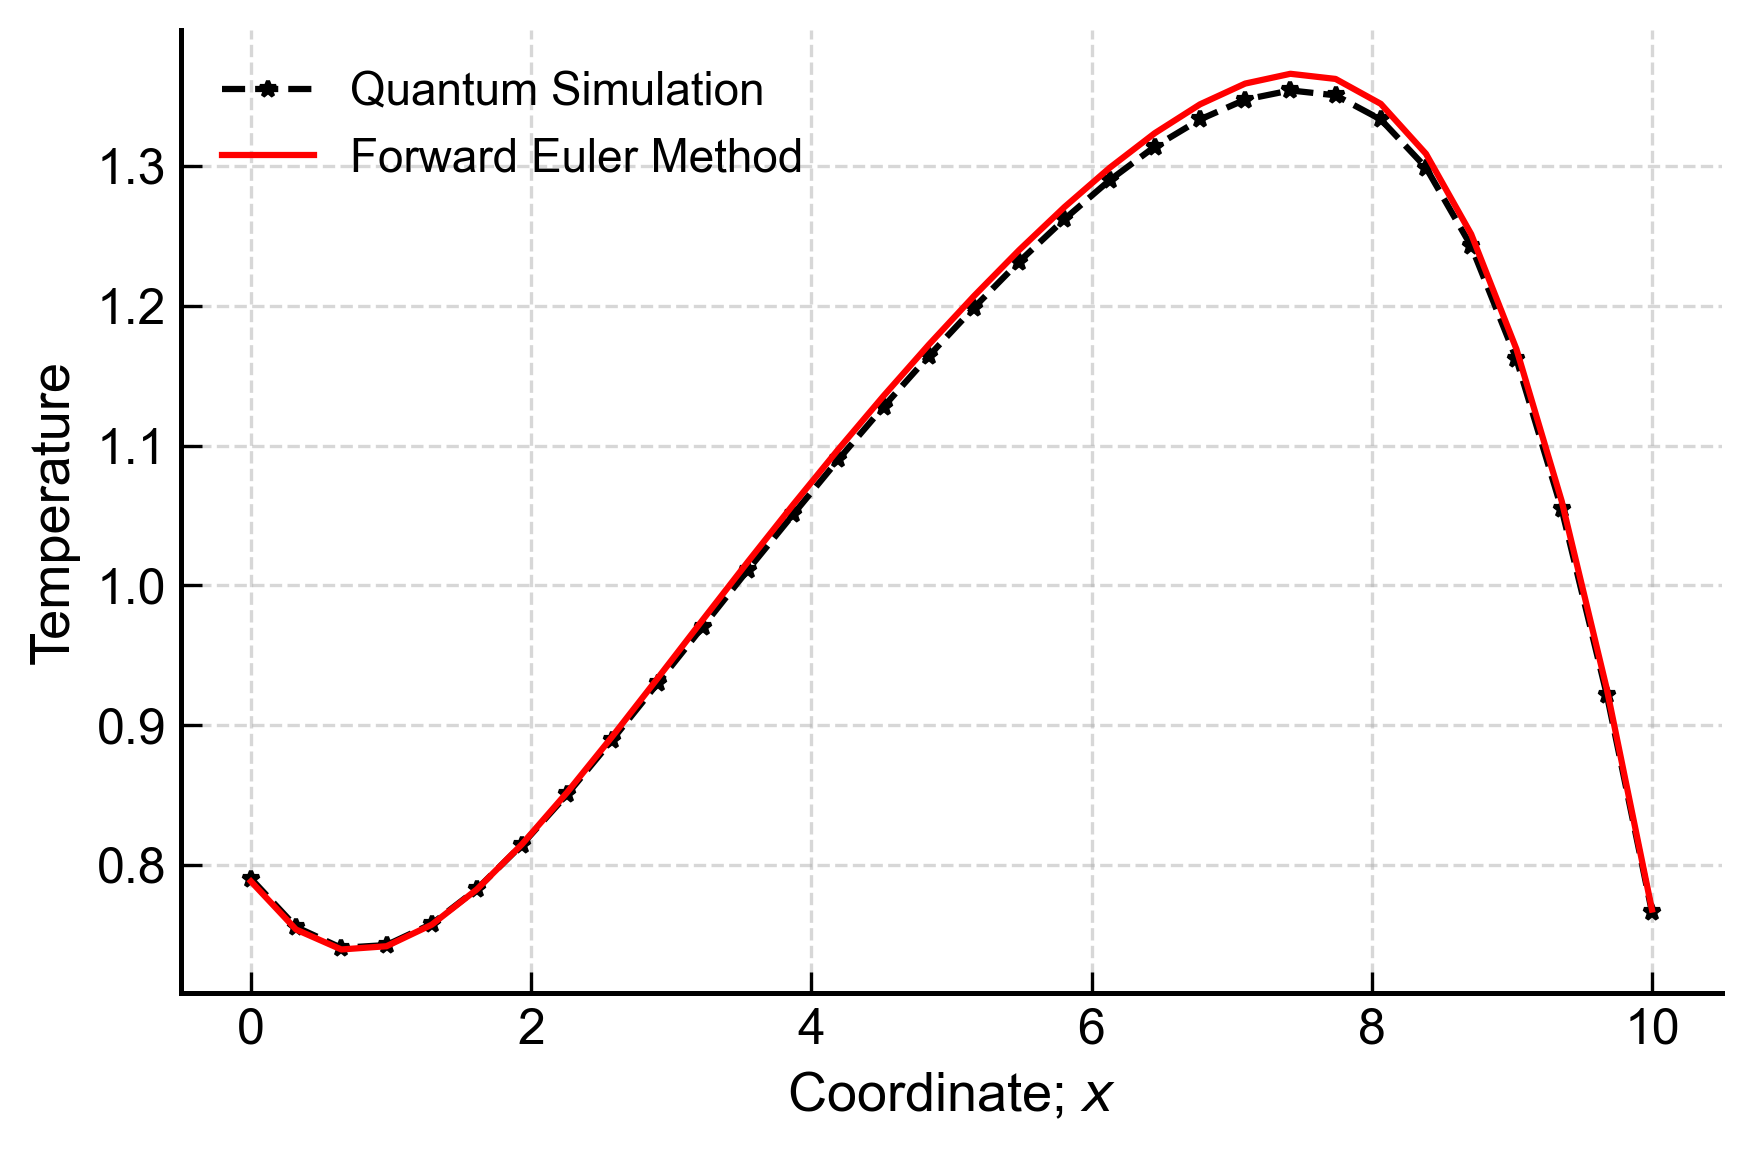

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Set consistent figure style
plt.rcParams.update({
    'font.family': 'Arial',           # Use a clean sans-serif font
    'font.size': 12,                  # Base font size
    'axes.linewidth': 1.2,           # Thicker axis lines
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'legend.frameon': False,         # No box around legend
    'legend.loc': 'best',
    'figure.dpi': 300,               # High-resolution output
})

# Create white-background figure
fig, ax = plt.subplots(figsize=(6, 4))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

k = 7
xi = (2 ** n_xi - 1) / 2 ** n_xi * np.pi / L_xi * k
y = output[2 ** (n_x + 1) * k : 2 ** (n_x + 1) * k + 2 ** n_x].cpu().numpy() * eta_norm * v_norm * 2 * L_xi * 2 ** (n_xi / 2) / (2 * np.pi * (2 ** n_xi - 1)) * np.exp(np.abs(xi) + 1j * L_xi * xi) * factor2# numerical

# Plotting
ax.plot(x, y.real, linestyle='--', marker='*', color='k', markersize=4,
        linewidth=1.5, label='Quantum Simulation')
ax.plot(x, U[:, -1], linestyle='-', color='red', linewidth=1.5, label='Forward Euler Method')

# ax.plot(x, y.real, color='navy', linestyle='--', label='Quantum Simulation')
# ax.plot(x, U[:, -1], color='black', linestyle='-', label='Forward Euler Method')

# ax.plot(x, y.real, color='orange', linestyle='-.', label='Quantum Simulation')
# ax.plot(x, U[:, -1], color='#333333', linestyle='-', label='Forward Euler Method')

# ax.plot(x, y.real, color='red', linestyle='--', marker='o', markersize=4, label='Quantum Simulation')
# ax.plot(x, U[:, -1], color='blue', linestyle='-', label='Forward Euler Method')





# Axis labels
ax.set_xlabel(r'Coordinate; $x$', fontsize=13)
ax.set_ylabel(r'Temperature', fontsize=13)

# Title (optional in publications; remove if panel label is used)
# ax.set_title(r'Simulation Time $T = 1$', fontsize=14)

# Add legend
ax.legend(fontsize=11)

# Improve layout and grid
ax.grid(True, linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Final adjustments
plt.tight_layout()
plt.show()

In [117]:
fig.savefig('comparison_plot.pdf', bbox_inches='tight')

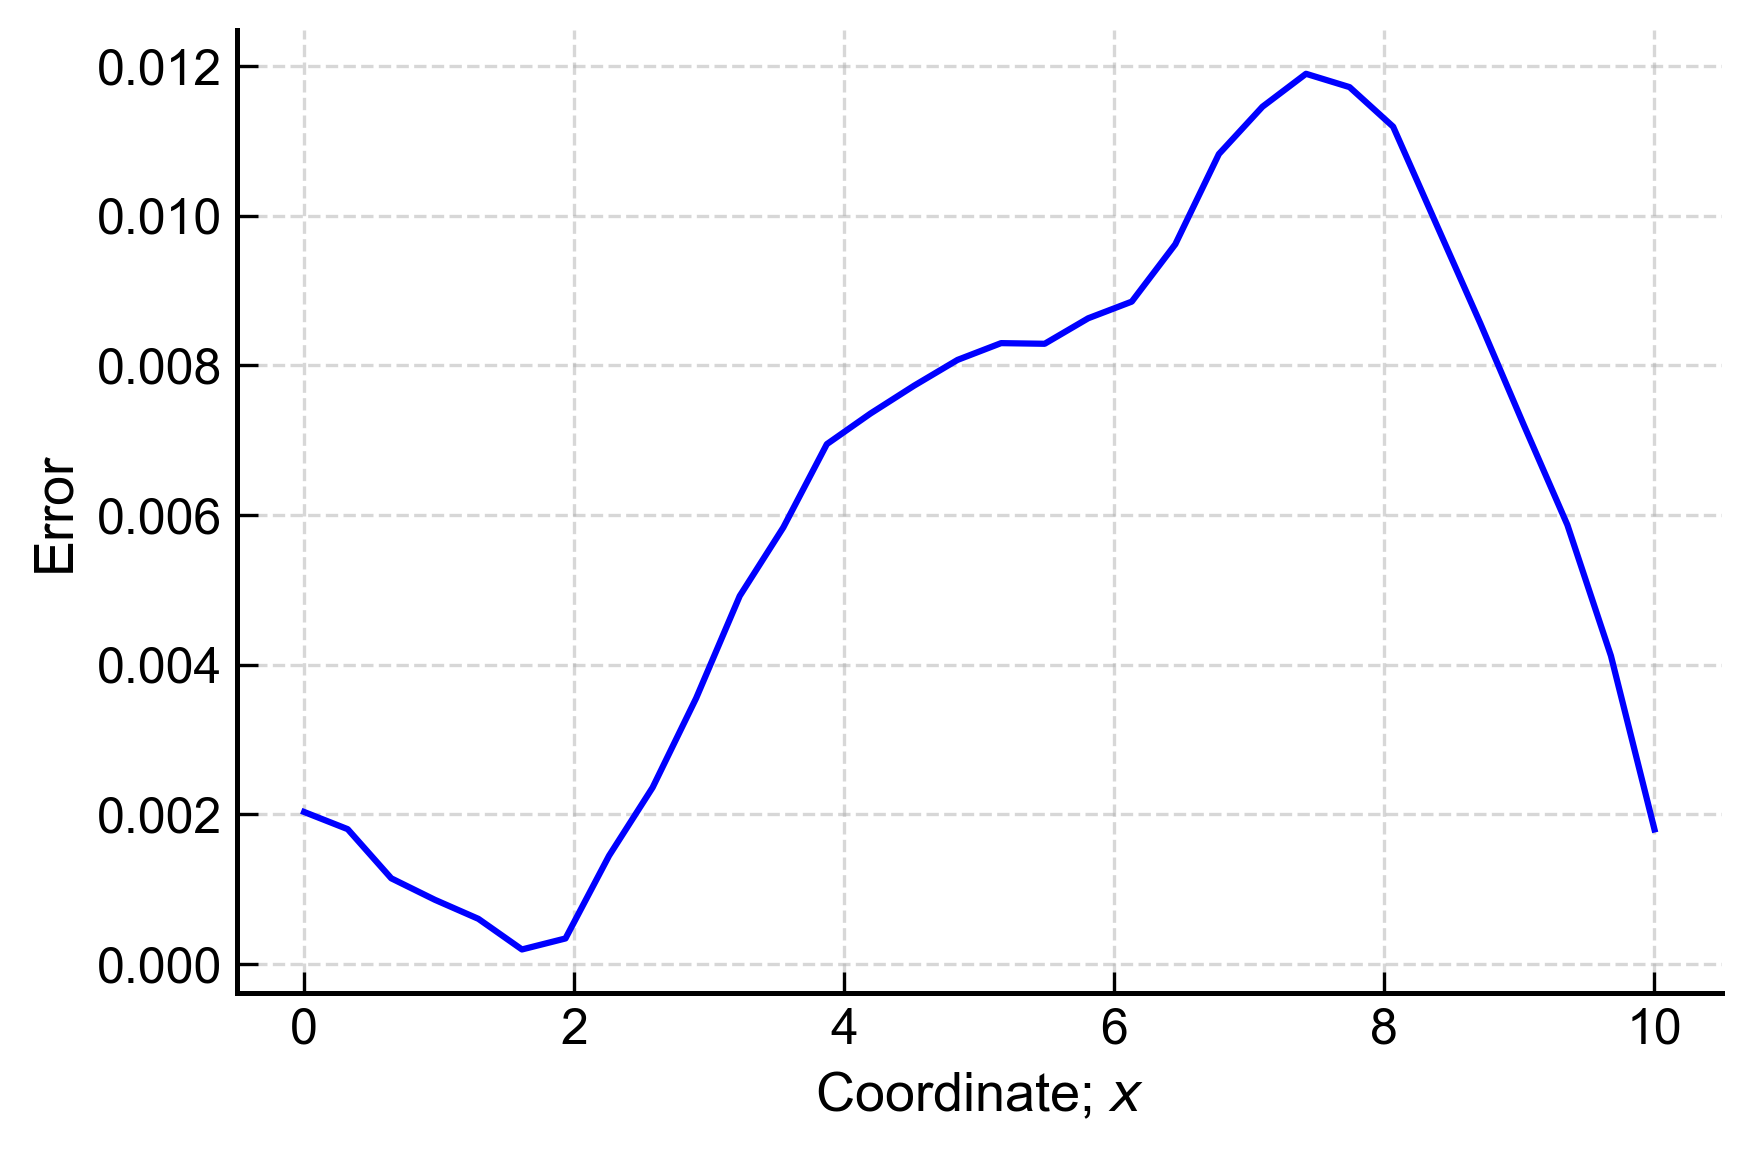

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Set consistent figure style
plt.rcParams.update({
    'font.family': 'Arial',           # Use a clean sans-serif font
    'font.size': 12,                  # Base font size
    'axes.linewidth': 1.2,           # Thicker axis lines
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'legend.frameon': False,         # No box around legend
    'legend.loc': 'best',
    'figure.dpi': 300,               # High-resolution output
})

# Create white-background figure
fig, ax = plt.subplots(figsize=(6, 4))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Your data setup
# k = 6
# xi = (2**n_eta - 1) / 2**n_eta * np.pi / L_eta * k
# y = output[2**(n_x + 1) * k : 2**(n_x + 1) * k + 2**n_x].cpu().numpy()
# y = y * eta_norm * v_norm * 2 * L_eta * 2**(n_eta / 2) / (2 * np.pi * (2**n_eta - 1)) \
#     * np.exp(np.abs(xi) + 1j * L_eta * xi) * factor2

# Plotting
# ax.plot(x, np.abs(y.real - U[:, -1]), linestyle='--', marker='*', color='k', markersize=4,
#         linewidth=1.5, label='Quantum Method')
error = y.real - U[:, -1]
ax.plot(x,  np.abs(error), linestyle='-', color='Blue', linewidth=1.5)

# Axis labels
ax.set_xlabel(r'Coordinate; $x$', fontsize=13)
ax.set_ylabel(r'Error', fontsize=13)

# Title (optional in publications; remove if panel label is used)
# ax.set_title(r'Simulation Time $T = 1$', fontsize=14)

# Add legend
# ax.legend(fontsize=11)

# Improve layout and grid
ax.grid(True, linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Final adjustments
plt.tight_layout()
plt.show()

In [119]:
fig.savefig('error.pdf', bbox_inches='tight')

In [120]:
MSE = np.sum(np.abs(error)**2) / Nx
MSE

np.float64(5.09032339866666e-05)

In [121]:
y_quantum_state = y / np.linalg.norm(y)
real_quantum_state = U[:, -1] / np.linalg.norm(U[:, -1])
fidelity = (np.abs(np.dot(y_quantum_state, real_quantum_state))) ** 2
fidelity

np.float64(0.9999913929867912)